In [1]:
import torch 
import lightning
import sys 
import os
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from lightning.pytorch.cli import LightningCLI
import matplotlib.pyplot as plt

/home/btang5/anaconda3/envs/ddpm_pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from jsonargparse import ArgumentParser

parser = ArgumentParser()
parser.add_argument('--model', type=lightning.LightningModule) # to ignore model
parser.add_argument('--data', type=lightning.LightningDataModule)
parser.add_argument('--trainer', type=lightning.Trainer)
config = parser.parse_path('/home/btang5/work/2025/geometric-aware-diffusion/config/diffusion/config_1.yaml')
config.pop("trainer", None)
config_init = parser.instantiate_classes(config)
model = config_init['model']

In [3]:
device="cuda:0"

In [4]:
ckpt = torch.load("/home/btang5/work/2025/geometric-aware-diffusion/logs/geo_diff/lightning_logs/version_0/checkpoints/epoch=342-step=33614.ckpt", map_location='cpu')

In [5]:
model.load_state_dict(ckpt['state_dict'])
model.eval()
model.to(device)

GeometricDiffusionDecoderOnlyModule(
  (geometric_decoder_only): GeometricDiffusionDecoderOnly(
    (autoencoder): AutoEncoderModule(
      (autoencoder): AdvancedAutoencoder(
        (encoder): Sequential(
          (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
          (6): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (8): ReLU()
          (9): Flatten(start_dim=1, end_dim=-1)
          (10): Linear(in_features=768, out_features=128, bias=True)
        )
        (decoder): Sequential(
          (0): Linear(in_features=128, out

In [6]:
config_init['data'].setup("test")

Files already downloaded and verified


In [7]:
testset = config_init['data'].valset

In [8]:
img = None
ct = 4
for _idx, i in enumerate(testset):
    img = i[0].unsqueeze(0).to(device)
    if _idx == ct:
        break
print(img.shape)

torch.Size([1, 3, 32, 32])


In [46]:
@torch.no_grad()
def get_intermediate(decoder_only, img):
    def inference(self, xT):
        # xT: [B, D] or [B, 1, D]
        # T: inference time step
        # Return [B,D]
        if len(xT.shape) == 2:
            xT = xT.unsqueeze(1)  # [B, 1, D]
        res = [xT]
        for _ in range(0, self.T):
            input = torch.cat(res, dim=1)  # [B, T, D]
            output = self.decoder_only(input)  # [B, T, D]
            res.append(output[:, -1:])  # [B, 1, D]
        return res[-1].squeeze(1), torch.cat(res, dim = 1)  # [B. D]
    model = decoder_only
    z = model.autoencoder.encode(img)
    samples_img = model.diffusion.sample(z)
    tokens = model.geometric(samples_img)
    print("Tokens shape:", tokens.shape)
    xT_token = tokens[:, -1:]  # [B, 1, D] the token corresponding to xT
    out, intermediate = inference(model.geometric_decoder_only, xT_token)
    out = out[:, : model.autoencoder.get_emb_dim()]
    img = model.autoencoder.decode(out)
    result = {}
    result["encoded"] = model.autoencoder.decode(z)
    return img, result, intermediate, xT_token

import tqdm
@torch.no_grad()
def get_images(autoencoder, latents):
    res = []
    for i in tqdm.tqdm(latents.squeeze(0)):
        decoded = autoencoder.decode(i[:autoencoder.get_emb_dim()].unsqueeze(0)) # [1, C, H, W]
        res.append(decoded)
    return torch.concat(res, dim = 0)

In [45]:
out = get_intermediate(decoder_only=model.geometric_decoder_only, img = img)

Tokens shape: torch.Size([1, 301, 288])


In [34]:
intermediate = out[2]
print(intermediate.shape)

torch.Size([1, 301, 288])


In [47]:
x_T = out[-1]
print(x_T.shape)

torch.Size([1, 1, 288])


In [48]:
token_img = model.geometric_decoder_only.autoencoder.decode(x_T.squeeze(0)[:,:128])

In [50]:
token_img.shape

torch.Size([1, 3, 32, 32])

In [ ]:
token_img

In [39]:
imgs = get_images(model.geometric_decoder_only.autoencoder, intermediate)

100%|██████████| 301/301 [00:00<00:00, 1472.21it/s]


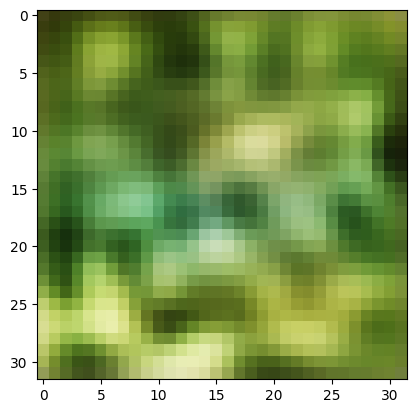

In [51]:
plt.imshow(token_img[0].cpu().squeeze(0).permute(1,2,0))

In [40]:
imgs[0].shape

torch.Size([3, 32, 32])

In [27]:
out[0].shape

torch.Size([1, 3, 32, 32])

In [24]:
latent = model.geometric_decoder_only.autoencoder.encode(img)
out = model.geometric_decoder_only.autoencoder.decode(latent)

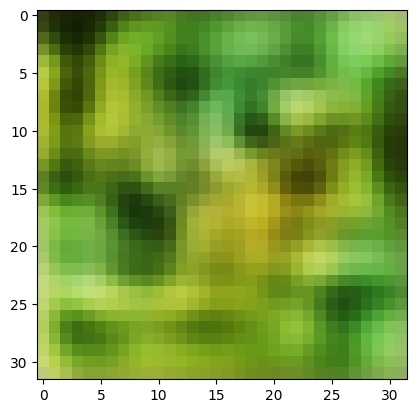

In [43]:
plt.imshow(imgs[0].cpu().squeeze(0).permute(1,2,0))

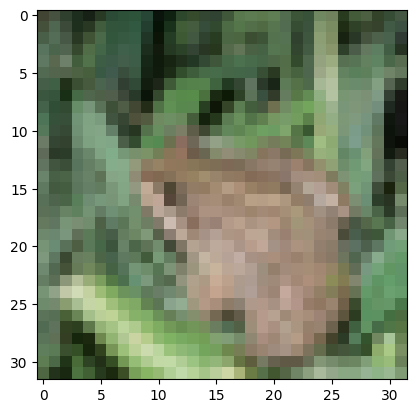

In [14]:
plt.imshow(img[0].cpu().squeeze(0).permute(1,2,0))